In [2]:
import os
from PIL import Image
import torchvision.transforms as transforms
import torch
import torchvision as torchvis
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import matplotlib.pyplot as plt
import numpy as np

In [3]:
clocks_dataset_dir = "clocks_dataset/train"

In [4]:
#check that the datapath is valid and populated
all_files = os.listdir(clocks_dataset_dir)
print(len(all_files))

20000


In [5]:
train_data = []
counter = 5000
for f in os.listdir(clocks_dataset_dir):
    if counter == 100:
      break
    if f.endswith(".png"):
        thisimg = torchvis.io.read_image(clocks_dataset_dir + "/" + f)
        train_data.append(thisimg)
    counter += 1
    print(counter)

print(len(train_data))

5001
5002
5003
5004
5005
5006
5007
5008
5009
5010
5011
5012
5013
5014
5015
5016
5017
5018
5019
5020
5021
5022
5023
5024
5025
5026
5027
5028
5029
5030
5031
5032
5033
5034
5035
5036
5037
5038
5039
5040
5041
5042
5043
5044
5045
5046
5047
5048
5049
5050
5051
5052
5053
5054
5055
5056
5057
5058
5059
5060
5061
5062
5063
5064
5065
5066
5067
5068
5069
5070
5071
5072
5073
5074
5075
5076
5077
5078
5079
5080
5081
5082
5083
5084
5085
5086
5087
5088
5089
5090
5091
5092
5093
5094
5095
5096
5097
5098
5099
5100
5101
5102
5103
5104
5105
5106
5107
5108
5109
5110
5111
5112
5113
5114
5115
5116
5117
5118
5119
5120
5121
5122
5123
5124
5125
5126
5127
5128
5129
5130
5131
5132
5133
5134
5135
5136
5137
5138
5139
5140
5141
5142
5143
5144
5145
5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200


In [6]:
images_tensor = torch.stack(train_data)

In [7]:
print(type(images_tensor))
print(images_tensor[0].shape)

<class 'torch.Tensor'>
torch.Size([3, 448, 448])


In [8]:
train_labels = []
counter = 0
for f in os.listdir(clocks_dataset_dir):
    if f.endswith(".txt"):
        with open(clocks_dataset_dir + "/" + f) as file:
            label = file.readline().strip()
            hour, minute = map(int, label.split(':'))
            label_tensor = torch.tensor([hour, minute], dtype=torch.float32)
            train_labels.append(label_tensor)
    counter += 1
    print(counter)



1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [9]:
labels_tensor = torch.stack(train_labels)

In [10]:
print(type(labels_tensor))

<class 'torch.Tensor'>


In [11]:
print(images_tensor.shape)

torch.Size([10000, 3, 448, 448])


In [12]:
train_tensor = images_tensor[:8000]
test_tensor = images_tensor[8000:]
print(train_tensor.shape)

torch.Size([8000, 3, 448, 448])


In [13]:
labels_train_tensor = labels_tensor[:8000]
labels_test_tensor = labels_tensor[8000:]
print(labels_train_tensor.shape)



torch.Size([8000, 2])


In [86]:
class ClocksDataset(Dataset):

    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.transform = transforms.Compose([
            transforms.ToPILImage(),            # Convert tensor to PIL image
            transforms.Resize((64, 64)),      # Resize the image to 112x112
            transforms.ToTensor()               # Convert PIL image back to tensor
        ])

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        image = (self.data[idx, :, :].float()/255)
        image = self.transform(image)
        label = self.labels[idx]
        return image, label

train_data = ClocksDataset(train_tensor, labels_train_tensor)
test_data = ClocksDataset(test_tensor, labels_test_tensor)

In [87]:
transform = transforms.Compose([
    transforms.Resize(size=(64,64))
])

In [88]:
image, label = train_data[0]
print(image.shape)

torch.Size([3, 64, 64])


In [118]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle=True, num_workers=0)

In [119]:
data_iter = iter(train_loader)
images, labels = next(data_iter)
print(f"Batch shape: {images.shape}, Labels shape: {labels.shape}")

Batch shape: torch.Size([32, 3, 64, 64]), Labels shape: torch.Size([32, 2])


In [120]:
images, labels = next(iter(train_loader))
print(images.shape)
print(labels.shape)

torch.Size([32, 3, 64, 64])
torch.Size([32, 2])


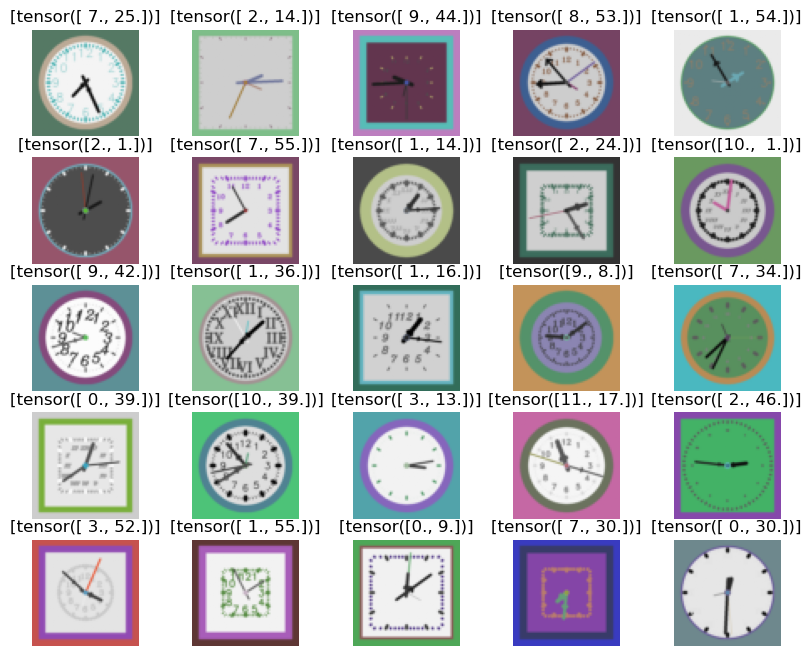

In [121]:
images, labels = next(iter(train_loader))
cols, rows = 5, 5
figure = plt.figure(figsize=(10, 8))

for i in range(cols * rows):
    figure.add_subplot(rows, cols, i+1)
    plt.title([labels[i]])
    plt.axis("off")
    img = images[i].numpy()
    img = np.transpose(img, (1, 2, 0))
    plt.imshow(img)
plt.show()

In [122]:
class TimePredictionNetwork(nn.Module):
    def __init__(self):
        super(TimePredictionNetwork, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)  # Added another conv layer
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.relu = nn.ReLU()
        
        # Adjusted the fully connected layers to match the output size
        self.fc1 = nn.Linear(256 * 2 * 2, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 2)  # Output 2 values

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))  # Output: (batch_size, 16, 32, 32)
        x = self.pool(self.relu(self.conv2(x)))  # Output: (batch_size, 32, 16, 16)
        x = self.pool(self.relu(self.conv3(x)))  # Output: (batch_size, 64, 8, 8)
        x = self.pool(self.relu(self.conv4(x)))  # Output: (batch_size, 128, 4, 4)
        x = self.pool(self.relu(self.conv5(x)))  # Output: (batch_size, 256, 2, 2)
        
        x = x.view(-1, 256 * 2 * 2)  # Flatten the tensor to shape (batch_size, 256*2*2)
        x = self.relu(self.fc1(x))     # Fully connected layer
        x = self.relu(self.fc2(x))     # Fully connected layer
        x = self.fc3(x)                # Output layer
        return x

# Initialize the model
model = TimePredictionNetwork()

# Print the model architecture
print(model)

TimePredictionNetwork(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
)


In [123]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(total_params)

983330


In [124]:
sample_input = torch.randn(100, 3, 64, 64)  # Batch size 100, 3 channels, 224x224 image
sample_output = model(sample_input)
print(f'Sample output shape: {sample_output.shape}')

Sample output shape: torch.Size([100, 2])


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    sample_input = torch.randn(100, 3, 448, 448)
    sample_output = model(sample_input)
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        print(outputs.shape)
        
    # print(f'Sample output shape: {sample_output.shape}')

In [129]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 30
for epoch in range(num_epochs):
    start_time = time.time()
    print(f"Starting epoch {epoch+1}/{num_epochs}...")
    model.train()
    running_loss = 0.0
    batch_count = 0
    epoch_batches = len(train_loader)
    print("model in training mode!")
    
    for inputs, labels in train_loader:
        # print(f"Processing batch {batch_count + 1}...")
        batch_start = time.time()
        
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        batch_count += 1
        batch_duration = time.time() - batch_start
        print(f"Batch {batch_count} processed, Duration: {batch_duration:.2f} seconds'")
    epoch_duration = time.time() - start_time
    print(f'Epoch {epoch+1}/{num_epochs} completed. Loss: {running_loss/epoch_batches:.4f}, Duration: {epoch_duration:.2f} seconds')

# Save the trained model
torch.save(model.state_dict(), 'weights.pth')

Starting epoch 1/30...
model in training mode!
Batch 1 processed, Duration: 0.03 seconds'
Batch 2 processed, Duration: 0.03 seconds'
Batch 3 processed, Duration: 0.03 seconds'
Batch 4 processed, Duration: 0.04 seconds'
Batch 5 processed, Duration: 0.04 seconds'
Batch 6 processed, Duration: 0.03 seconds'
Batch 7 processed, Duration: 0.03 seconds'
Batch 8 processed, Duration: 0.03 seconds'
Batch 9 processed, Duration: 0.03 seconds'
Batch 10 processed, Duration: 0.03 seconds'
Batch 11 processed, Duration: 0.03 seconds'
Batch 12 processed, Duration: 0.03 seconds'
Batch 13 processed, Duration: 0.03 seconds'
Batch 14 processed, Duration: 0.03 seconds'
Batch 15 processed, Duration: 0.03 seconds'
Batch 16 processed, Duration: 0.04 seconds'
Batch 17 processed, Duration: 0.03 seconds'
Batch 18 processed, Duration: 0.03 seconds'
Batch 19 processed, Duration: 0.03 seconds'
Batch 20 processed, Duration: 0.03 seconds'
Batch 21 processed, Duration: 0.03 seconds'
Batch 22 processed, Duration: 0.03 sec

In [130]:
model.eval()
test_loss = 0.0
allinputs = []
alloutputs = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        allinputs.extend(labels)
        outputs = model(inputs)
        alloutputs.extend(outputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

In [132]:
for ix, x in enumerate(allinputs):
    print(x)
    print(alloutputs[ix])

tensor([ 1., 20.])
tensor([ 1.4260, 21.5577])
tensor([10., 59.])
tensor([ 9.9393, 52.7873])
tensor([ 1., 49.])
tensor([ 1.3681, 51.1497])
tensor([11., 41.])
tensor([ 7.1634, 36.2125])
tensor([ 1., 33.])
tensor([ 0.3651, 34.7620])
tensor([ 2., 41.])
tensor([ 1.5420, 38.8661])
tensor([ 1., 10.])
tensor([1.8456, 5.2694])
tensor([ 7., 37.])
tensor([ 7.9039, 38.1053])
tensor([ 5., 38.])
tensor([ 5.1772, 38.6296])
tensor([ 4., 14.])
tensor([ 5.0411, 19.4194])
tensor([ 2., 56.])
tensor([ 2.5654, 51.9538])
tensor([10., 55.])
tensor([ 9.3082, 54.9579])
tensor([7., 1.])
tensor([ 3.5487, 27.2671])
tensor([11., 59.])
tensor([ 9.3569, 63.5243])
tensor([10., 44.])
tensor([ 9.1212, 47.0835])
tensor([ 7., 31.])
tensor([ 6.4092, 32.3268])
tensor([ 8., 35.])
tensor([ 6.8301, 40.3170])
tensor([ 4., 51.])
tensor([ 4.4499, 53.0076])
tensor([ 3., 41.])
tensor([ 2.8478, 40.6763])
tensor([ 9., 25.])
tensor([ 9.2213, 25.6898])
tensor([11., 49.])
tensor([11.7310, 53.5693])
tensor([ 6., 48.])
tensor([ 5.7627, 42

In [131]:
test_loss /= len(test_loader)
print(f'Test Loss: {test_loss:.4f}')

Test Loss: 37.3592
